In [1]:
import os
import sys
import torch
import json
import plotly.express as px
from transformer_lens import utils
from datasets import load_dataset

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("../scripts")
from error_eval import *
from plots import *

In [2]:
cwd = os.getcwd()
cwd = cwd.split("notebooks")[0]
print(cwd)

/n/data2/hms/dbmi/sunyaev/lab/dlee/ai_safety/sae_pathology/


In [3]:
from e2e_sae.scripts.analysis.utils import create_run_df, get_df_gpt2
df = get_df_gpt2()

performance_df = df.copy()

#get models that were used in the performance plot of the paper
performance_df = df.loc[(df["ratio"] == 60) & (df["seed"] == 0) & (df["n_samples"] == 400_000)]

# Ignore specialised runs
performance_df = performance_df.loc[
    ~performance_df["name"].str.contains("seed-comparison")
    & ~performance_df["name"].str.contains("lr-comparison")
    & ~performance_df["name"].str.contains("lower-downstream")
    & -performance_df["name"].str.contains("e2e-local")
    & ~performance_df["name"].str.contains("recon-all")
    & ~performance_df["name"].str.contains("misc_")]

columns_list = ["id", "sae_pos", "run_type", "layer", "L0", "CELossIncrease", "alive_dict_elements"]
df_local = performance_df[(performance_df["layer"] == 6) & (performance_df["run_type"] == "local")].sort_values("L0")
df_e2e = performance_df[(performance_df["layer"] == 6) & (performance_df["run_type"] == "e2e")].sort_values("L0")
df_downstream = performance_df[(performance_df["layer"] == 6) & (performance_df["run_type"] == "downstream")].sort_values("L0")

Processing runs: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 299/299 [00:11<00:00, 26.91it/s]


In [4]:
df_local

,name,id,sae_pos,model_name,run_type,layer,seed,n_samples,lr,ratio,...,explained_var_ln_layer-3,explained_var_ln_layer-5,explained_var_ln_layer-12,explained_var_ln_layer-1,explained_var_ln_layer-4,recon_loss_layer-1,recon_loss_layer-3,recon_loss_layer-5,recon_loss_layer-4,recon_loss_layer-12
296,seed-0_lpcoeff-20.0_in-to-out-1.0_lr-0.0005_ra...,ahxwn90o,blocks.6.hook_resid_pre,gpt2-small,local,6,0,400000,0.0005,60.0,...,1.0,1.0,0.320016,1.0,1.0,0.0,0.0,0.0,0.0,56.488811
297,seed-0_lpcoeff-13.0_in-to-out-1.0_lr-0.0005_ra...,43zmudf4,blocks.6.hook_resid_pre,gpt2-small,local,6,0,400000,0.0005,60.0,...,1.0,1.0,0.587133,1.0,1.0,0.0,0.0,0.0,0.0,35.255581
285,seed-0_lpcoeff-8.0_in-to-out-1.0_lr-0.0005_rat...,unji5etq,blocks.6.hook_resid_pre,gpt2-small,local,6,0,400000,0.0005,60.0,...,1.0,1.0,0.751137,1.0,1.0,0.0,0.0,0.0,0.0,21.462133
295,seed-0_lpcoeff-6.0_in-to-out-1.0_lr-0.0005_rat...,jup3glm9,blocks.6.hook_resid_pre,gpt2-small,local,6,0,400000,0.0005,60.0,...,1.0,1.0,0.808091,1.0,1.0,0.0,0.0,0.0,0.0,16.424322
287,seed-0_lpcoeff-5.0_in-to-out-1.0_lr-0.0005_rat...,h9hrelni,blocks.6.hook_resid_pre,gpt2-small,local,6,0,400000,0.0005,60.0,...,1.0,1.0,0.834990,1.0,1.0,0.0,0.0,0.0,0.0,14.063370
298,seed-0_lpcoeff-4.0_in-to-out-1.0_lr-0.0005_rat...,1jy3m5j0,blocks.6.hook_resid_pre,gpt2-small,local,6,0,400000,0.0005,60.0,...,1.0,1.0,0.862926,1.0,1.0,0.0,0.0,0.0,0.0,11.595212
212,seed-0_lpcoeff-3.0_in-to-out-1.0_lr-0.0005_rat...,4nlqrc2y,blocks.6.hook_resid_pre,gpt2-small,local,6,0,400000,0.0005,60.0,...,1.0,1.0,0.887240,1.0,1.0,0.0,0.0,0.0,0.0,9.404200
213,seed-0_lpcoeff-2.0_in-to-out-1.0_lr-0.0005_rat...,2wvu1zs5,blocks.6.hook_resid_pre,gpt2-small,local,6,0,400000,0.0005,60.0,...,1.0,1.0,0.918096,1.0,1.0,0.0,0.0,0.0,0.0,6.622472
286,seed-0_lpcoeff-1.0_in-to-out-1.0_lr-0.0005_rat...,uiwt81f1,blocks.6.hook_resid_pre,gpt2-small,local,6,0,400000,0.0005,60.0,...,1.0,1.0,0.953734,1.0,1.0,0.0,0.0,0.0,0.0,3.573500


# Functions

In [9]:
directory = "/n/data2/hms/dbmi/sunyaev/lab/dlee/ai_safety/sae_pathology/results/feature_extrapolation/gpt2_resid_pre/"
pos = "all"
def read_file(model_id, nrows = None):
    data_path = directory + f'/e2e_{model_id}_layer_6_seed_23_batchsize_1_pos_{pos}.csv'

    if nrows:
        result_df = pd.read_csv(data_path, nrows=nrows)
    else:
        result_df = pd.read_csv(data_path)

    return result_df

def get_alive_dict_elements(model_id):
    result_df = read_file(model_id, nrows = 3)

    if type(result_df["alive_dict_elements"][0]) == str:
        return int(result_df["alive_dict_elements"][0].split("(")[1].split(",")[0])
    else:
        return result_df["alive_dict_elements"][0]


def get_mean_df(model_id):
    result_df = read_file(model_id)
    result_df = result_df.drop(['token', 'alive_dict_elements'], axis=1)
    mean_df = pd.DataFrame(result_df.mean(axis=0)).T
    return mean_df

def get_median_df(model_id):
    result_df = read_file(model_id)
    result_df = result_df.drop(['token', 'alive_dict_elements'], axis=1)
    median_df = pd.DataFrame(result_df.median(axis=0)).T
    return median_df

## Functions

In [10]:
def read_file(model_id, nrows = None):
    data_path = directory + f'/e2e_{model_id}_layer_6_seed_23_batchsize_1_pos_{pos}.csv'

    if nrows:
        result_df = pd.read_csv(data_path, nrows=nrows)
    else:
        result_df = pd.read_csv(data_path)

    return result_df

def get_alive_dict_elements(model_id):
    result_df = read_file(model_id, nrows = 3)

    if type(result_df["alive_dict_elements"][0]) == str:
        return int(result_df["alive_dict_elements"][0].split("(")[1].split(",")[0])
    else:
        return result_df["alive_dict_elements"][0]


def get_mean_df(model_id):
    result_df = read_file(model_id)
    result_df = result_df.drop(['token', 'alive_dict_elements'], axis=1)
    mean_df = pd.DataFrame(result_df.mean(axis=0)).T
    return mean_df

def get_median_df(model_id):
    result_df = read_file(model_id)
    result_df = result_df.drop(['token', 'alive_dict_elements'], axis=1)
    median_df = pd.DataFrame(result_df.median(axis=0)).T
    return median_df

## Let's first get a number of active dictionary, compare it to the result from the paper

In [122]:
df_interest = pd.concat([df_local, df_e2e, df_downstream]).reset_index(drop = True)

pos = 'all'
layers = [6]
sae_name = 'gpt2_resid_pre'
directory = data_path = os.path.join(
        cwd + 'results/feature_extrapolation',
        sae_name)

#this model didn't run yet
# df_interest = df_interest[df_interest["id"] != "fqdgjxfe"]

# df_interest["model_name"] = [f"e2e_{x}" for x in df_interest["id"]]

In [123]:
df_interest["active_dict_elements_observed"] = [get_alive_dict_elements(x) for x in df_interest["id"]]

In [124]:
df_interest[["id", "active_dict_elements_observed"]]

,id,active_dict_elements_observed
0,ahxwn90o,3942
1,43zmudf4,9023
2,unji5etq,16969
3,jup3glm9,21004
4,h9hrelni,23769
5,1jy3m5j0,26523
6,4nlqrc2y,29899
7,2wvu1zs5,33786
8,uiwt81f1,37549
9,4zcbb4au,18940


[Text(0.5, 0, 'Alive Dict Elements from Braun et al.'),
 Text(0, 0.5, 'Inferred Alive Dict Elements')]

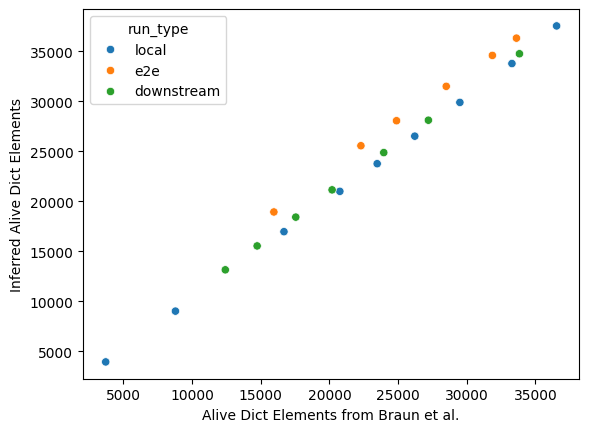

In [125]:
g = sns.scatterplot(data=df_interest, x="alive_dict_elements", y="active_dict_elements_observed", hue = "run_type")
g.set(xlabel="Alive Dict Elements from Braun et al.", ylabel = "Inferred Alive Dict Elements")


## Plot KL Divergence

### for mean

In [126]:
df_interest["mean_df"] = [get_mean_df(x) for x in df_interest["id"]]

In [127]:
mean_df_all = pd.concat(list(df_interest["mean_df"])).reset_index()

In [128]:
mean_df_all["run_type"] = df_interest["run_type"]
mean_df_all["L0"] = df_interest["L0"]

col_names = [f'{direction_type}_feature_length_{length}_kl' for length in range(1, 211, 10) for direction_type in ["alive", "active", "dead"]]
mean_df_melt = pd.melt(mean_df_all, id_vars=['reconstruction_error', 'L0', 'run_type'], value_vars=col_names, ignore_index=False)
mean_df_melt["metric"] = "KL"

# col_names = [f'error_length_{length}_loss' for length in range(1, 211, 10)]
# mean_df_melt_loss = pd.melt(mean_df, id_vars=['reconstruction_error', 'L0', 'type'], value_vars=col_names, ignore_index=False)
# mean_df_melt_loss["metric"] = "Loss"

# mean_df_melt = pd.concat([mean_df_melt_kl, mean_df_melt_loss])
mean_df_melt["perturbation_length"] = mean_df_melt["variable"].str.split("_", expand = True)[3].astype(int)
mean_df_melt["perturbation_type"] = mean_df_melt["variable"].str.split("_", expand = True)[0]

mean_df_melt["L0"] = [f"{x:.1f}" for x in mean_df_melt["L0"]]
mean_df_melt["L0"] = mean_df_melt["L0"].astype(float)

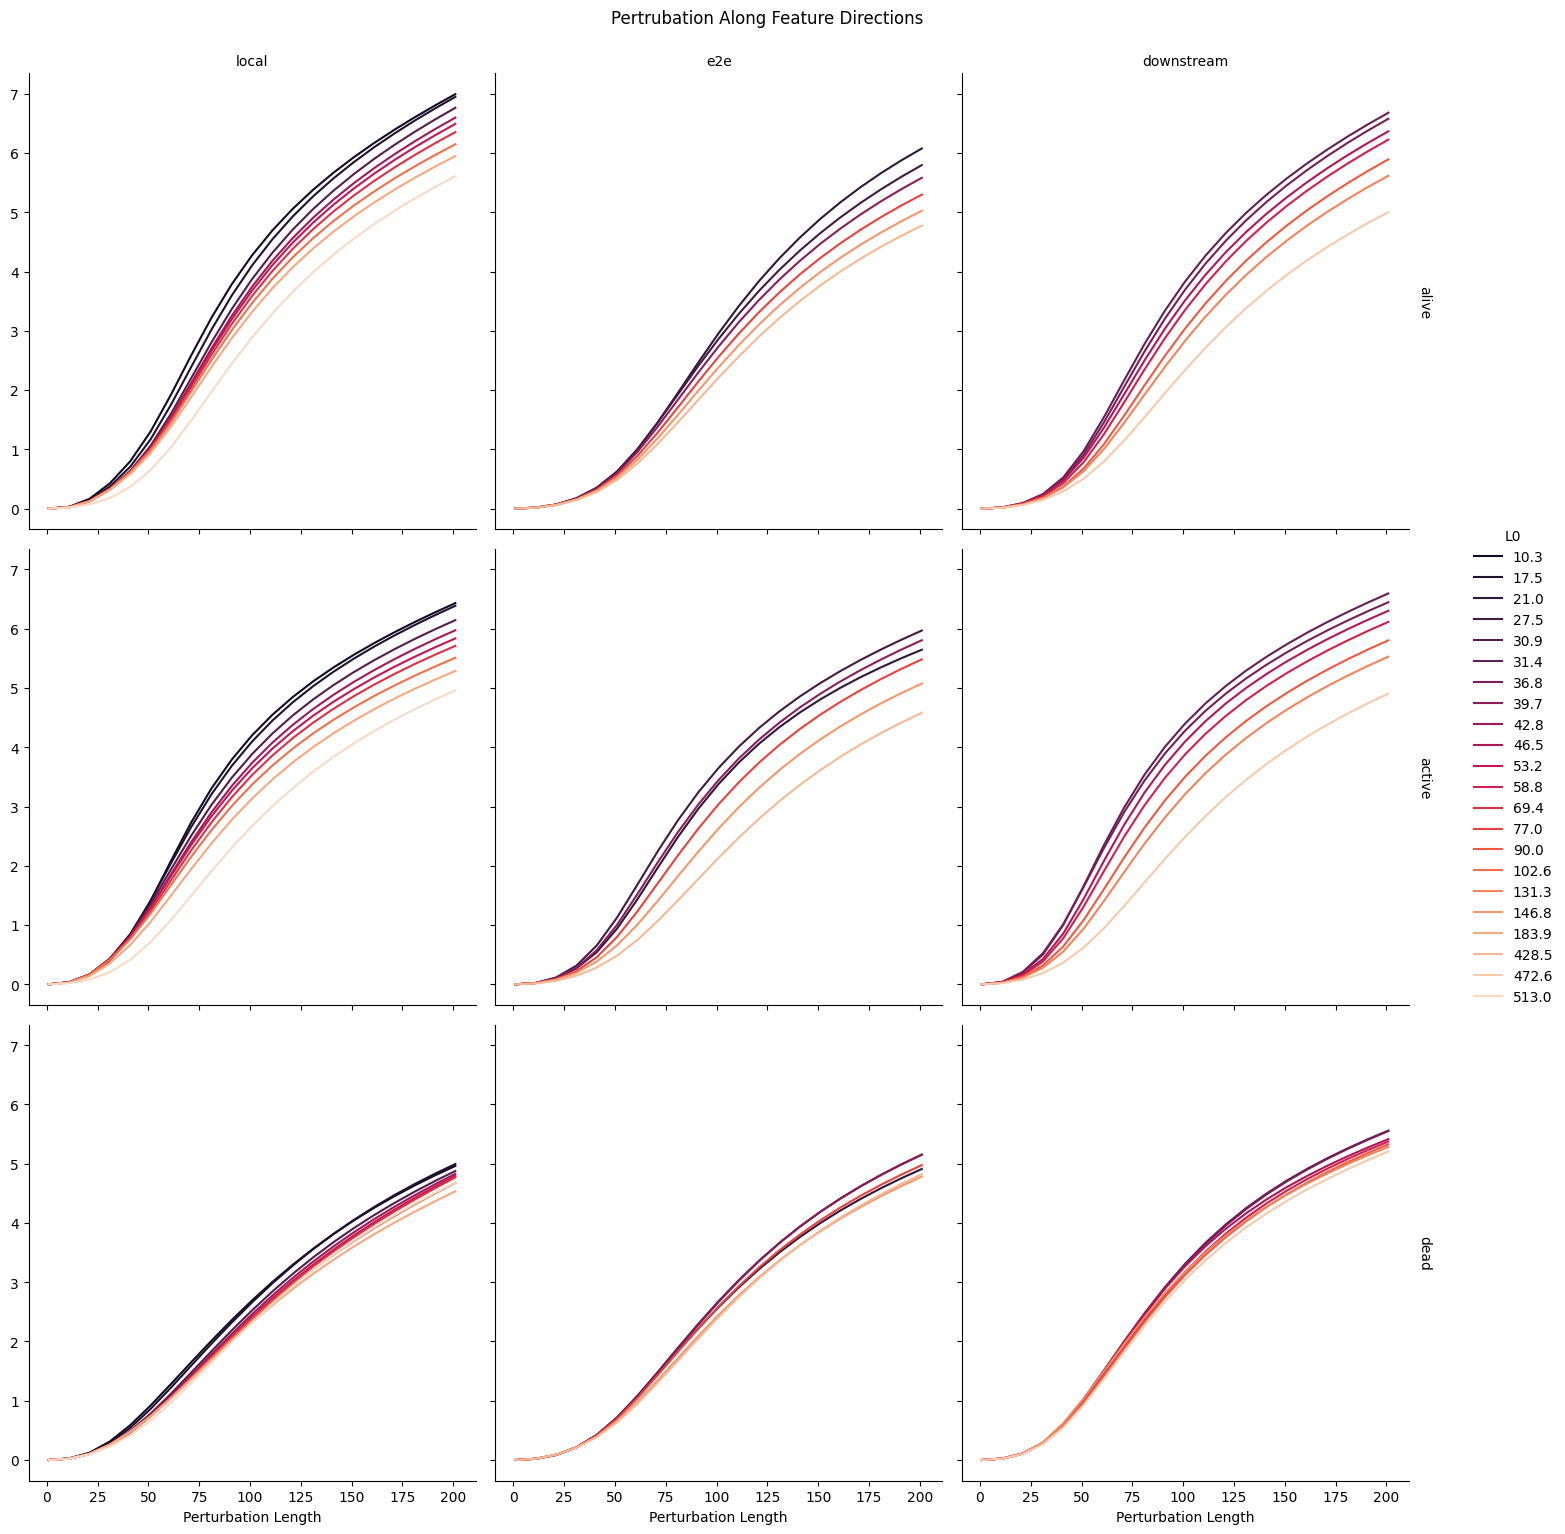

In [129]:
# sns.set_theme(style="darkgrid")

mean_df_melt_plot = mean_df_melt.copy()
# mean_df_melt_plot = mean_df_melt[(mean_df_melt["L0"] >= 30)]

g = sns.FacetGrid(mean_df_melt_plot, row = "perturbation_type", col="run_type", height=5, margin_titles=True, hue = "L0", 
                  palette = 'rocket')

g.map(sns.lineplot, "perturbation_length", "value")

g.set_titles(col_template="{col_name}", row_template="{row_name}")

g.fig.suptitle(f'Pertrubation Along Feature Directions', y = 1.02)

g.set(xlabel="Perturbation Length", ylabel = None)
g.add_legend()

# plt.savefig("extrapolation_error.svg", format="svg", bbox_inches="tight")

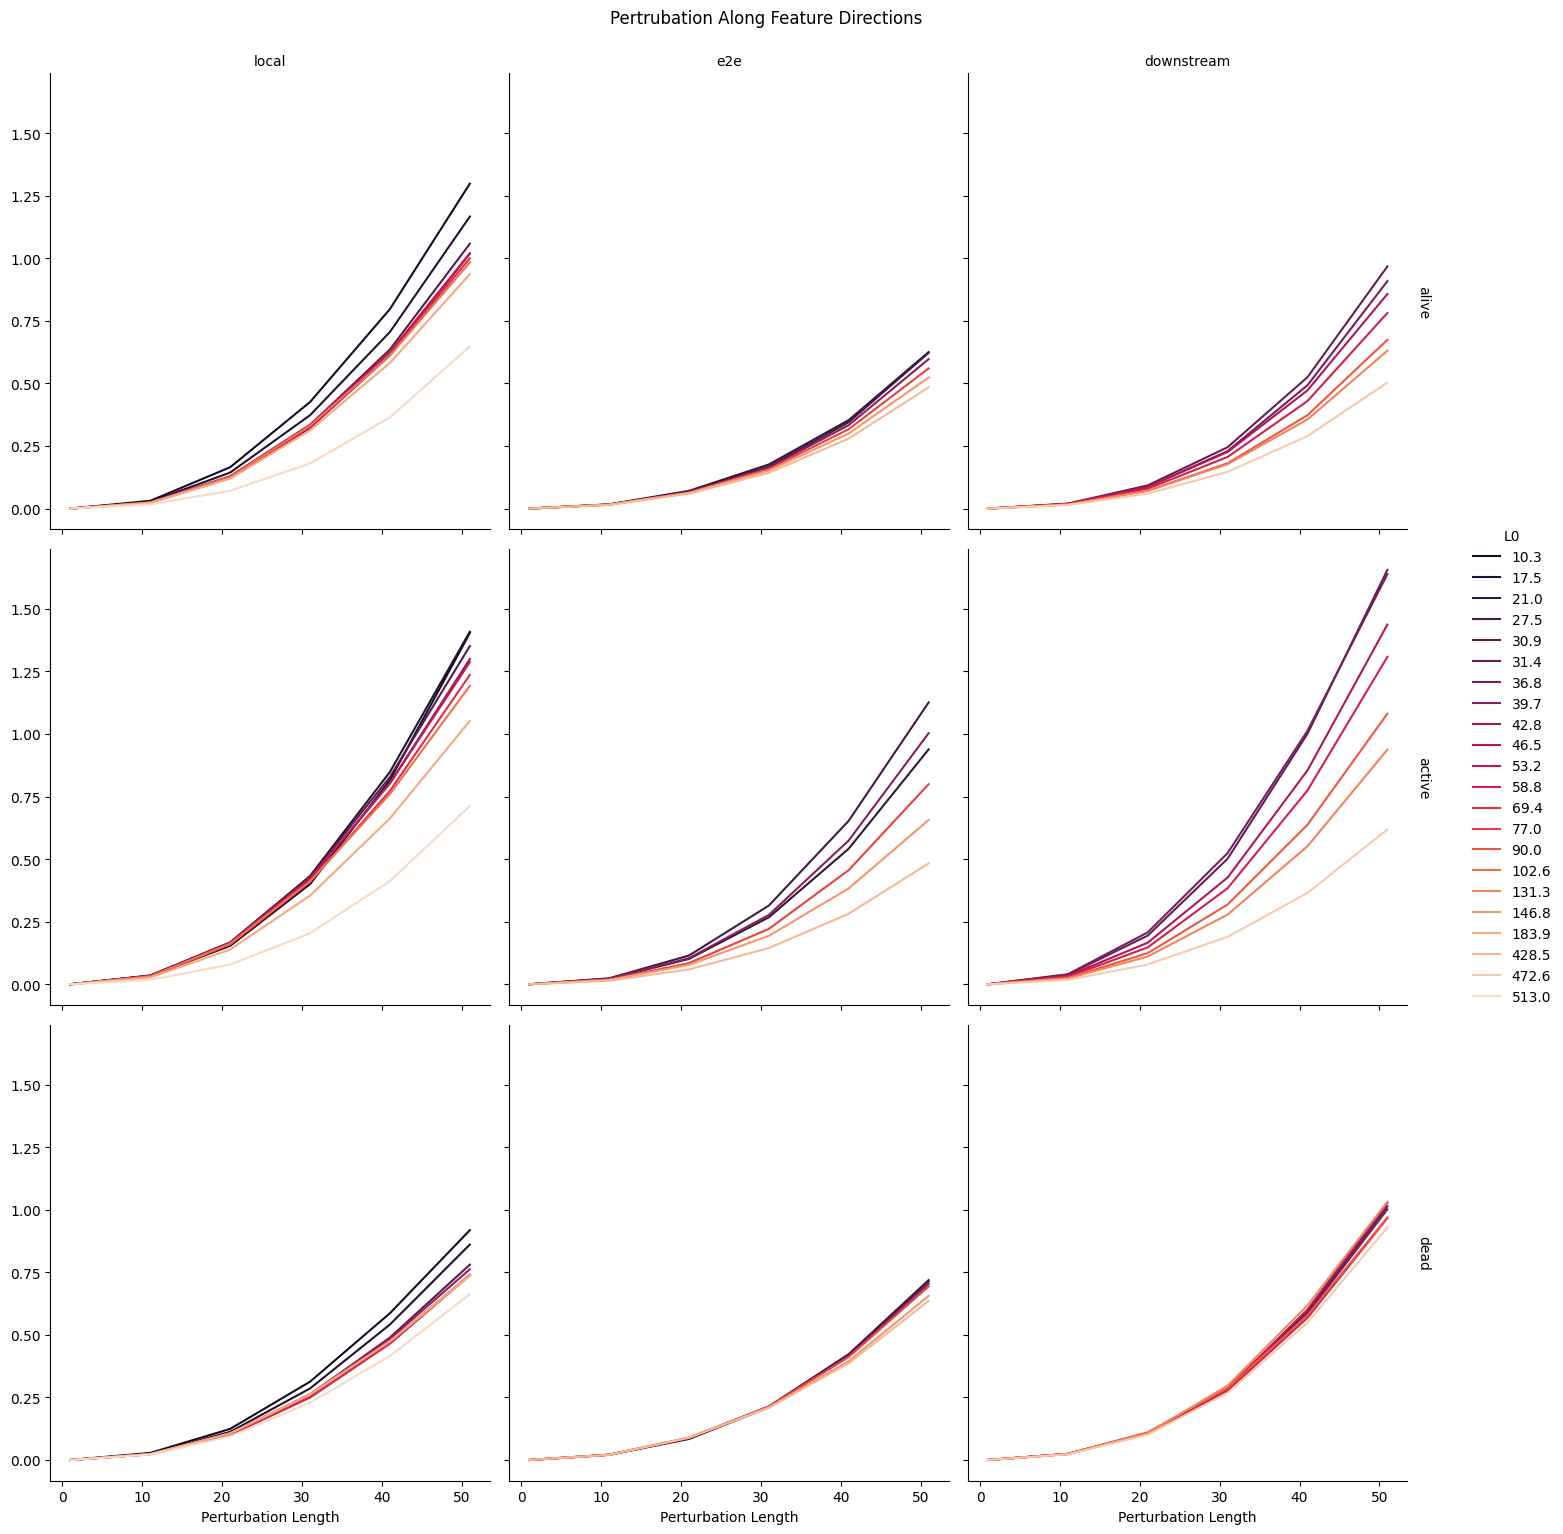

In [130]:
# sns.set_theme(style="darkgrid")

mean_df_melt_plot = mean_df_melt[(mean_df_melt["perturbation_length"] <= 51)]


g = sns.FacetGrid(mean_df_melt_plot, row = "perturbation_type", col="run_type", height=5, margin_titles=True, hue = "L0", 
                  palette = 'rocket')

g.map(sns.lineplot, "perturbation_length", "value")

g.set_titles(col_template="{col_name}", row_template="{row_name}")

g.fig.suptitle(f'Pertrubation Along Feature Directions', y = 1.02)

g.set(xlabel="Perturbation Length", ylabel = None)
g.add_legend()


# plt.savefig("extrapolation_error.svg", format="svg", bbox_inches="tight")

### Plot median

Median looks roughly similar to the mean

In [ ]:
df_interest["median_df"] = [get_median_df(x) for x in df_interest["id"]]

In [105]:
median_df_all = pd.concat(list(df_interest["median_df"])).reset_index()

In [106]:
median_df_all["run_type"] = df_interest["run_type"]
median_df_all["L0"] = df_interest["L0"]

col_names = [f'{direction_type}_feature_length_{length}_kl' for length in range(1, 211, 10) for direction_type in ["alive", "active", "dead"]]
median_df_melt = pd.melt(median_df_all, id_vars=['reconstruction_error', 'L0', 'run_type'], value_vars=col_names, ignore_index=False)
median_df_melt["metric"] = "KL"

median_df_melt["perturbation_length"] = median_df_melt["variable"].str.split("_", expand = True)[3].astype(int)
median_df_melt["perturbation_type"] = median_df_melt["variable"].str.split("_", expand = True)[0]

median_df_melt["L0"] = [f"{x:.1f}" for x in median_df_melt["L0"]]
median_df_melt["L0"] = median_df_melt["L0"].astype(float)

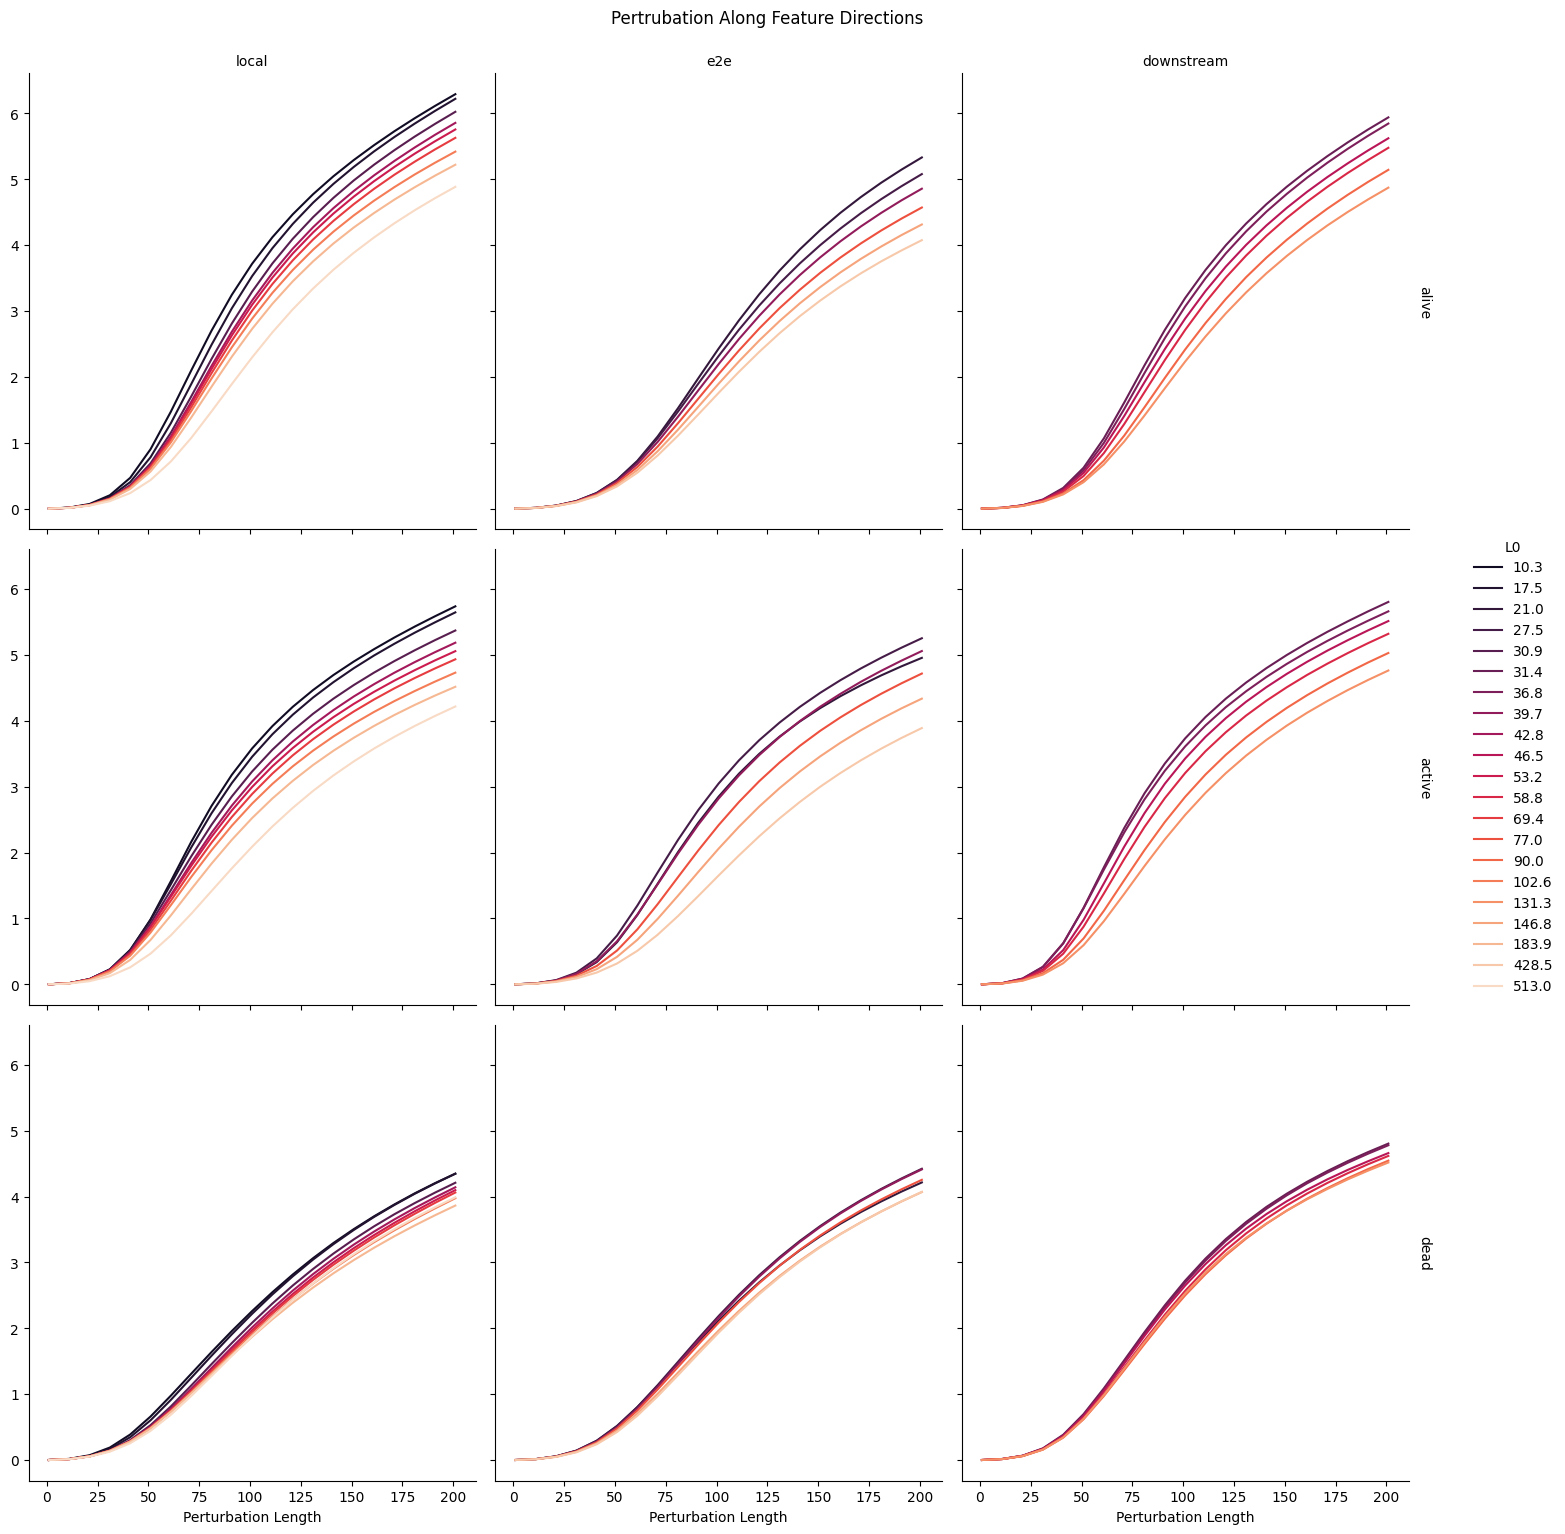

In [108]:
# sns.set_theme(style="darkgrid")

median_df_melt_plot = median_df_melt.copy()
# mean_df_melt_plot = mean_df_melt[(mean_df_melt["L0"] >= 30)]

g = sns.FacetGrid(median_df_melt_plot, row = "perturbation_type", col="run_type", height=5, margin_titles=True, hue = "L0", 
                  palette = 'rocket')

g.map(sns.lineplot, "perturbation_length", "value")

g.set_titles(col_template="{col_name}", row_template="{row_name}")

g.fig.suptitle(f'Pertrubation Along Feature Directions', y = 1.02)

g.set(xlabel="Perturbation Length", ylabel = None)
g.add_legend()

# plt.savefig("extrapolation_error.svg", format="svg", bbox_inches="tight")

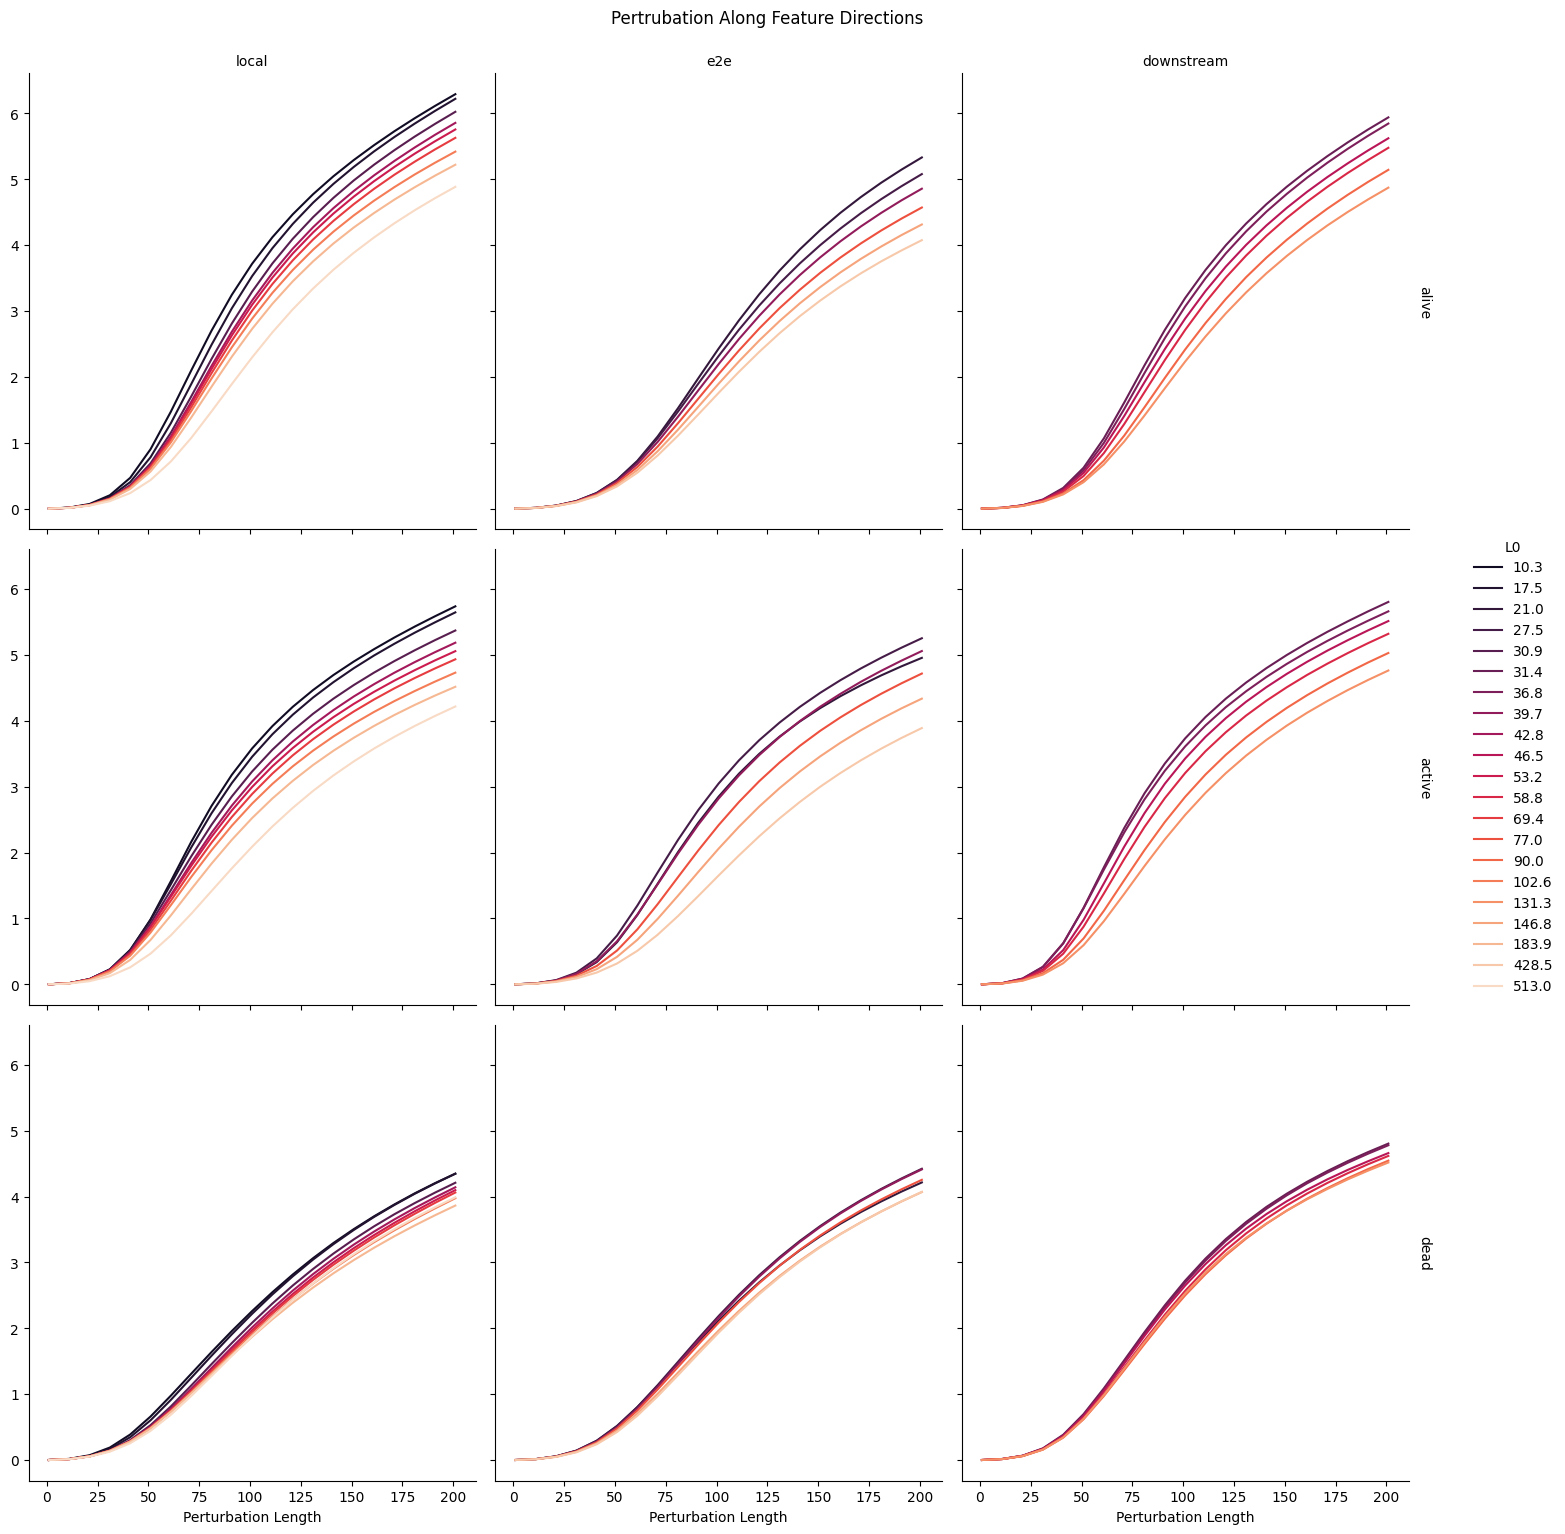

In [109]:
# sns.set_theme(style="darkgrid")

mean_df_melt_plot = median_df_melt[(median_df_melt["perturbation_length"] <= 51)]

# mean_df_melt_plot = mean_df_melt[(mean_df_melt["L0"] >= 30)]

g = sns.FacetGrid(median_df_melt_plot, row = "perturbation_type", col="run_type", height=5, margin_titles=True, hue = "L0", 
                  palette = 'rocket')

g.map(sns.lineplot, "perturbation_length", "value")

g.set_titles(col_template="{col_name}", row_template="{row_name}")

g.fig.suptitle(f'Pertrubation Along Feature Directions', y = 1.02)

g.set(xlabel="Perturbation Length", ylabel = None)
g.add_legend()

# plt.savefig("extrapolation_error.svg", format="svg", bbox_inches="tight")

# Plot For A SAE Local Model

In [11]:
model_id = "uiwt81f1"
df = read_file(model_id)

In [12]:
col_names = [f'{feature_type}_feature_length_{length}_kl' for feature_type in ["alive", "active", "dead"] for length in range(1, 211, 10)]
col_names_201 = [f'{feature_type}_feature_length_{length}_kl' for feature_type in ["alive", "active", "dead"] for length in [201]]


<Axes: xlabel='error_length', ylabel='value'>

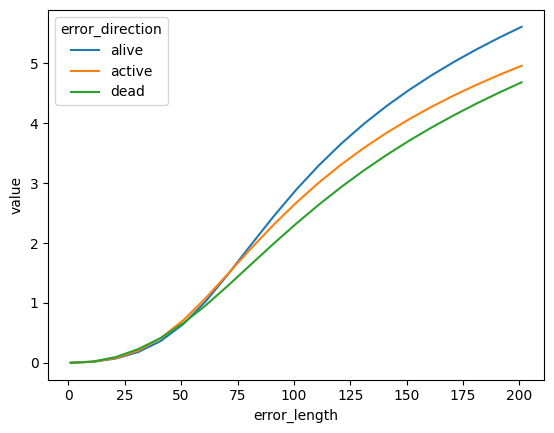

In [9]:
## for e2e SAE 4d5ksz89

sns.lineplot(data=mean_df_melt, x="error_length", y="value", hue = "error_direction")


<Axes: xlabel='error_length', ylabel='value'>

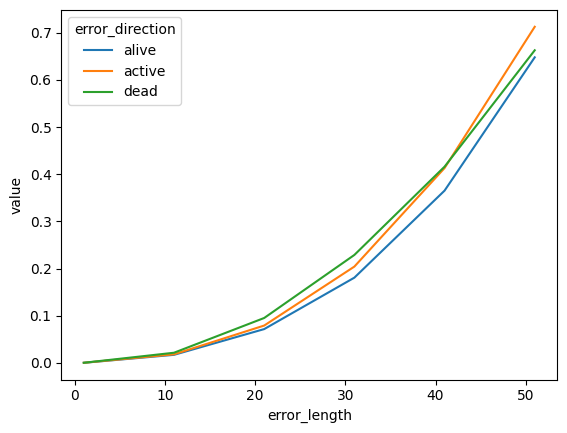

In [11]:
mean_df_melt_plot = mean_df_melt[(mean_df_melt["error_length"] <= 51)]

sns.lineplot(data=mean_df_melt_plot, x="error_length", y="value", hue = "error_direction")


In [15]:
var_df = pd.DataFrame(df.var(axis=0)).T
var_df_melt = pd.melt(var_df, id_vars=['reconstruction_error'], value_vars=col_names, ignore_index=False)
var_df_melt["error_length"] = var_df_melt["variable"].str.split("_", expand = True)[3].astype(int)
var_df_melt["error_direction"] = var_df_melt["variable"].str.split("_", expand = True)[0]

<Axes: xlabel='error_length', ylabel='value'>

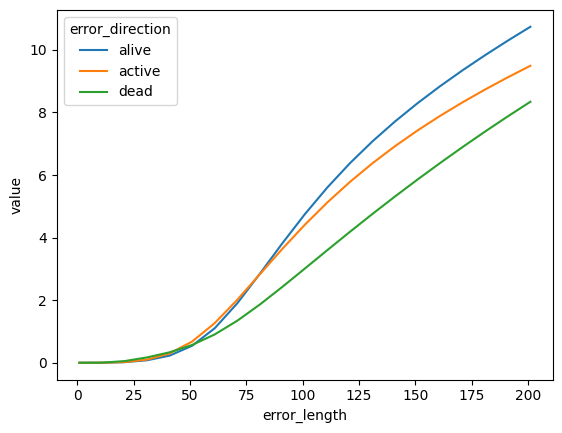

In [18]:
## for e2e SAE 4d5ksz89

sns.lineplot(data=var_df_melt, x="error_length", y="value", hue = "error_direction")


<Axes: xlabel='error_length', ylabel='value'>

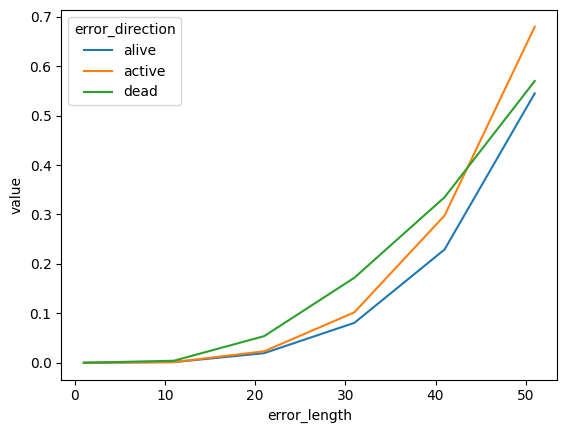

In [19]:
var_df_melt_plot = var_df_melt[(var_df_melt["error_length"] <= 51)]

sns.lineplot(data=var_df_melt_plot, x="error_length", y="value", hue = "error_direction")


## Plot some samples

In [13]:
for i in range(9):
    df_sample = df.sample(n = 7)
    df_sample_melt = pd.melt(df_sample, id_vars=['token'], value_vars=col_names, ignore_index=False)
    df_sample_melt["perturb_length"] = df_sample_melt["variable"].str.split("_", expand = True)[3].astype(int)
    df_sample_melt["perturb_direction"] = df_sample_melt["variable"].str.split("_", expand = True)[0]
    df_sample_melt["index"] = df_sample_melt.index
    df_sample_melt["iteration"] = i

    if i == 0:
        df_sample_melt_all = df_sample_melt.copy()
    else:
        df_sample_melt_all = pd.concat([df_sample_melt_all, df_sample_melt])

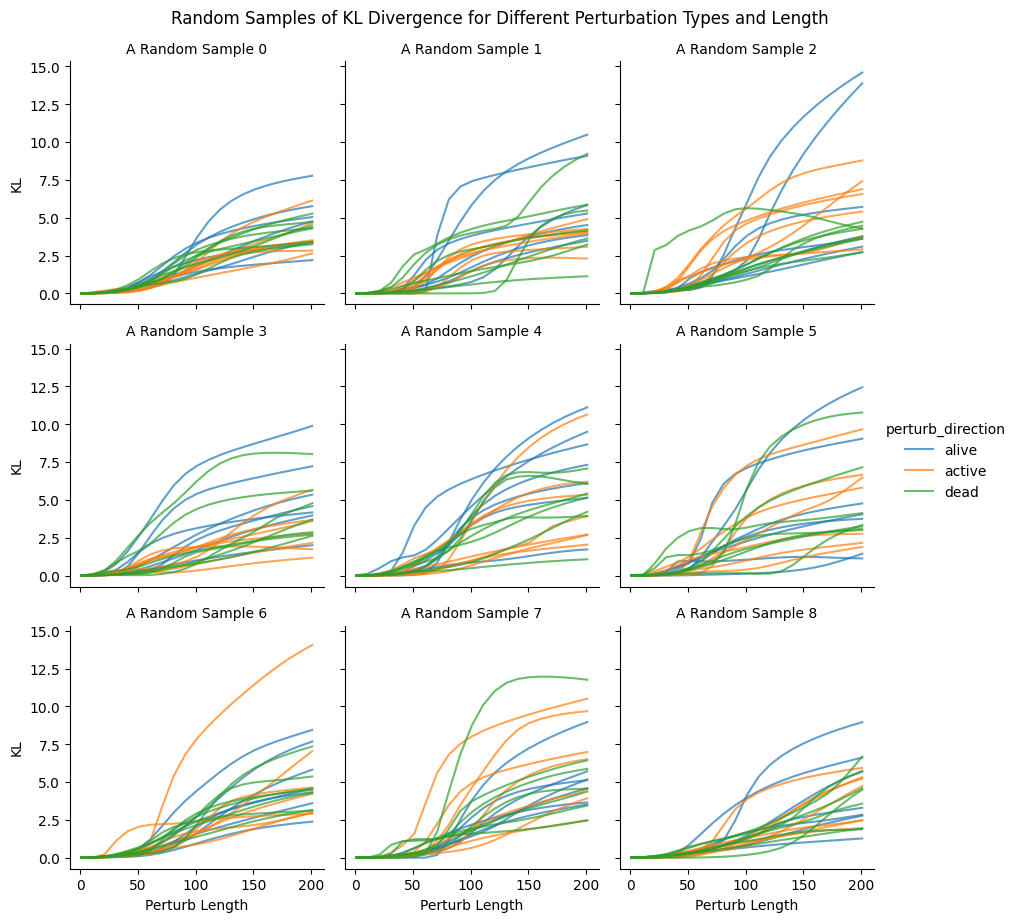

In [14]:
# g = sns.FacetGrid(df_sample_melt_all, col="iteration", col_wrap = 3, height=5, margin_titles=True, hue = "perturb_direction")

g = sns.FacetGrid(df_sample_melt_all, col="iteration", col_wrap = 3, hue = "perturb_direction")

g.map_dataframe(sns.lineplot, x='perturb_length', y='value', units='index', estimator=None, alpha = 0.7)

g.set_titles(col_template="A Random Sample {col_name}")

g.fig.suptitle(f'Random Samples of KL Divergence for Different Perturbation Types and Length', y = 1.02)

g.set(xlabel="Perturb Length", ylabel = "KL")
g.add_legend()

# plt.savefig("extrapolation_error.svg", format="svg", bbox_inches="tight")

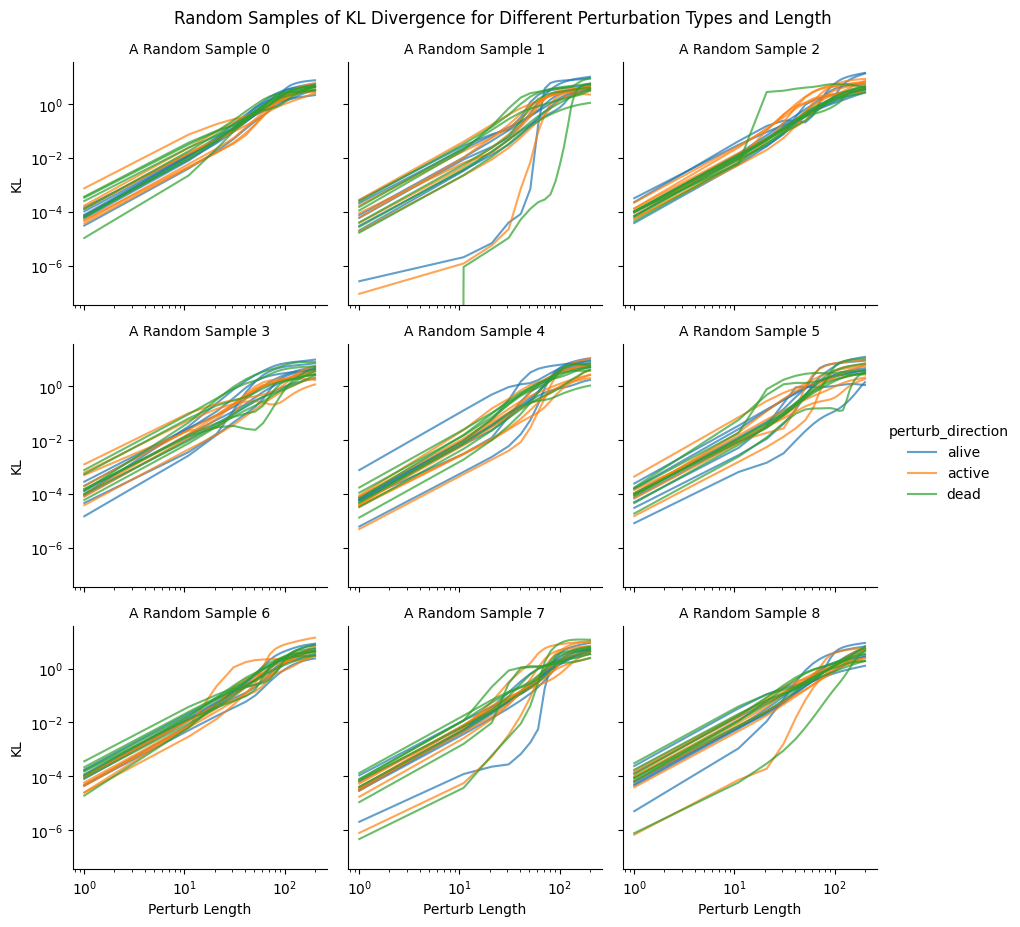

In [16]:
# g = sns.FacetGrid(df_sample_melt_all, col="iteration", col_wrap = 3, height=5, margin_titles=True, hue = "perturb_direction")

g = sns.FacetGrid(df_sample_melt_all, col="iteration", col_wrap = 3, hue = "perturb_direction")

g.map_dataframe(sns.lineplot, x='perturb_length', y='value', units='index', estimator=None, alpha = 0.7)

g.set_titles(col_template="A Random Sample {col_name}")

g.fig.suptitle(f'Random Samples of KL Divergence for Different Perturbation Types and Length', y = 1.02)

g.set(yscale = 'log', xscale = 'log')
g.set(xlabel="Perturb Length", ylabel = "KL")
g.add_legend()

# plt.savefig("extrapolation_error.svg", format="svg", bbox_inches="tight")